In [1]:
import re
import itertools
from collections import Counter
import pandas as pd

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
from nltk.tokenize import RegexpTokenizer

from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
from tqdm import tqdm

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/wuga/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/wuga/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Constant

In [2]:
itemID = 'asin'
userID = 'reviewerID'
rating = 'overall'
reviewText = 'reviewText'
columnToDrop = ['reviewTime','helpful','reviewerName','summary']
dataPath = 'data/baby/'
dataName = 'Baby_5.json'

## Load Data

In [3]:
df = pd.read_json(dataPath+dataName, lines=True).drop(columnToDrop, axis=1)
df[reviewText] = df[reviewText].apply(lambda x: x.lower())
df.head()

,asin,overall,reviewText,reviewerID,unixReviewTime
0,097293751X,5,perfect for new parents. we were able to keep ...,A1HK2FQW6KXQB2,1373932800
1,097293751X,5,this book is such a life saver. it has been s...,A19K65VY14D13R,1372464000
2,097293751X,5,helps me know exactly how my babies day has go...,A2LL1TGG90977E,1395187200
3,097293751X,5,i bought this a few times for my older son and...,A5G19RYX8599E,1376697600
4,097293751X,4,i wanted an alternative to printing out daily ...,A2496A4EWMLQ7,1396310400


## Vectorize

In [4]:
tokenizer = Tokenizer()
text = df[reviewText].tolist()
tokenizer.fit_on_texts(text)
df['vector'] = tokenizer.texts_to_sequences(text)

In [5]:
df_word_index = pd.DataFrame(list(tokenizer.word_index.items()), columns=['word','index'])

In [6]:
#get english stopwords
en_stopwords = set(stopwords.words('english'))

#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords or word.isspace():
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [7]:
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()

tokens = itertools.chain.from_iterable(df[reviewText].apply(lambda x: nltk.word_tokenize(x)+[' ']).tolist())

bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)

bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), 
                               columns=['bigram','freq']).sort_values(by='freq', ascending=False)
bigramFreqTable = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]

In [8]:
bigramFinder.apply_freq_filter(100)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                              columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)

In [9]:
#df_keyphrases = pd.concat([bigramFreqTable[['bigram']].head(50), bigramPMITable[['bigram']].head(50)])
df_keyphrases = bigramPMITable[['bigram']].head(50)
df_keyphrases['Phrases'] = df_keyphrases['bigram'].apply(lambda x: ' '.join(x))
df_keyphrases = df_keyphrases[['Phrases']].reset_index(drop=True)
keyphrases = df_keyphrases['Phrases'].tolist()

In [10]:
df['keyVector'] = df[reviewText].apply(lambda x: [1. if key in x else 0 for key in keyphrases])

In [11]:
df['UserIndex'] = df[userID].astype('category').cat.rename_categories(range(0, df[userID].nunique()))
df['ItemIndex'] = df[itemID].astype('category').cat.rename_categories(range(0, df[itemID].nunique()))
df['Binary'] = (df[rating] > 3)*1

In [12]:
df_user_name = df[['UserIndex',userID]]
df_item_name = df[['ItemIndex',itemID]]

In [13]:
df = df.drop([itemID, userID, reviewText], axis=1)

## DataFrames

In [14]:
df.head()

,overall,unixReviewTime,vector,keyVector,UserIndex,ItemIndex,Binary
0,5,1373932800,"[152, 9, 204, 586, 19, 106, 185, 3, 127, 1924,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2496,0,1
1,5,1372464000,"[8, 834, 7, 451, 6, 572, 1189, 5, 50, 111, 18,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1343,0,1
2,5,1395187200,"[539, 80, 205, 619, 119, 12, 233, 212, 50, 118...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8234,0,1
3,5,1376697600,"[4, 87, 8, 6, 157, 243, 9, 12, 352, 75, 2, 17,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",15045,0,1
4,4,1396310400,"[4, 284, 85, 1524, 3, 7983, 39, 919, 7886, 612...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5810,0,1


In [15]:
df_word_index.head()

,word,index
0,fawn,29643
1,knittingschoo,30033
2,bulkyi,44866
3,soloud,54175
4,tolorate,55380


In [16]:
df_keyphrases.head()

,Phrases
0,pottery barn
1,fuzzi bunz
2,mei tai
3,eddie bauer
4,maxi cosi


In [17]:
df_user_name.head()

,UserIndex,reviewerID
0,2496,A1HK2FQW6KXQB2
1,1343,A19K65VY14D13R
2,8234,A2LL1TGG90977E
3,15045,A5G19RYX8599E
4,5810,A2496A4EWMLQ7


In [18]:
df_item_name.head()

,ItemIndex,asin
0,0,097293751X
1,0,097293751X
2,0,097293751X
3,0,097293751X
4,0,097293751X


## Statistic

In [19]:
print("Number of User: {0}".format(df_user_name['UserIndex'].nunique()))
print("Number of Item: {0}".format(df_item_name['ItemIndex'].nunique()))
print("Number of Positive Review: {0}".format(sum(df['Binary'].tolist())))

Number of User: 19445
Number of Item: 7050
Number of Positive Review: 126525


In [20]:
review_lengths = df.vector.apply(lambda x: len(x)).tolist()

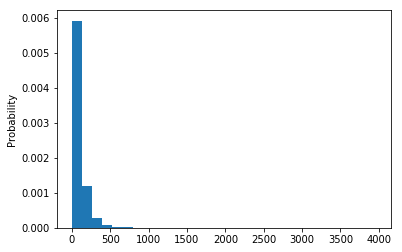

In [21]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.hist(review_lengths, normed=True, bins=30)
plt.ylabel('Probability');

## Save

In [22]:
df.to_csv(dataPath+'Data.csv')
df_word_index.to_csv(dataPath+'WordIndex.csv')
df_keyphrases.to_csv(dataPath+'KeyPhrases.csv')
df_user_name.to_csv(dataPath+'UserIndex.csv')
df_item_name.to_csv(dataPath+'ItemIndex.csv')